In [1]:
import os
TITANIC_PATH = os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition","Dataset")

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
y = train_data.Survived
X = train_data.drop(['Survived'],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_val , y_train, y_val= train_test_split(X,y,test_size=0.20)


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
# To szybka klasa która robi i zamienia dane kategoryczne na numeryczne
# Zamieniamy na dane numeryczne ABC i jeśli chcemy zamienic na numeryczne to bierzemy one hot encode

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#Imputer wypełnia dane na odstawie tej Strategoo
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age",'Pclass',])),
        ("scaler", StandardScaler()),
        ("imputer", SimpleImputer(strategy="median")),
    ])


In [7]:

num_pipeline.fit_transform(X_train)

array([[-0.10520516,  0.83827931],
       [ 0.02967173, -0.36022444],
       [ 1.44587899,  0.83827931],
       ...,
       [-0.10520516,  0.83827931],
       [-1.92604307, -0.36022444],
       [ 0.50174082, -1.55872819]])

In [8]:
# Inspired from stackoverflow.com/questions/25239958

# Szybka klasa która wylicza najczęściej występujacy element itp
# 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [9]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(['Embarked','Name','Sex','Ticket','Cabin'])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])



In [10]:
cat_pipeline.fit_transform(X_train)

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [11]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

#Mamy tutaj Feature Union którea łączy nasze cechy  i pipelien'y
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [12]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5)

In [13]:
# SVC predictors

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

pipe_1 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='rbf'))])
pipe_2 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='poly'))])
pipe_3 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC(kernel='linear'))])
pipe_4 = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())])

param_grid = {
            'classifier__gamma': [0.001,0.003, 0.01,0.03, 0.1,0.3, 1, 10, 100,200],
            'classifier__C': [0.001,0.003, 0.01, 0.03, 0.1,0.3, 1, 10, 100,200]
}
param_grid_2 = {
            'classifier__C': [0.001, 0.01 ,0.03, 0.1,0.3, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe_1, param_grid, cv=kfold)
grid_2 = GridSearchCV(pipe_2, param_grid, cv=kfold)
grid_3 = GridSearchCV(pipe_3, param_grid, cv=kfold)
grid_4 = GridSearchCV(pipe_4, param_grid_2, cv=kfold)

grid_1.fit(X_train, y_train)
grid_2.fit(X_train, y_train)
grid_3.fit(X_train, y_train)
grid_4.fit(X_train, y_train)



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

preds = [(grid_1.best_estimator_,'SVC_rbf'),(grid_2.best_estimator_,'SVC_poly'),(grid_3.best_estimator_,'SVC_rbf'),(grid_4.best_estimator_,'LogReg')]

for clf,name in preds:
    clf.fit(X_val, y_val)
    y_pred = clf.predict(X_val)
    print(name, accuracy_score(y_val, y_pred))


In [ ]:
prediction_1 = grid_1.best_estimator_.predict(test_data)
prediction_2= grid_2.best_estimator_.predict(test_data)
prediction_3= grid_3.best_estimator_.predict(test_data)
prediction_4= grid_4.best_estimator_.predict(test_data)

In [ ]:
import numpy as np

data=np.vstack([prediction_1,prediction_2,prediction_3,prediction_4]).T
prediction_1 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_1]).T
prediction_2 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_2]).T
prediction_3 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_3]).T
prediction_4 = np.vstack([np.arange(len(X_train)+1,len(X_train)+len(prediction_1)+1,1),prediction_4]).T
df_prediction_1 = pd.DataFrame(prediction_1,columns=['PassengerId','Survived'])
df_prediction_2 = pd.DataFrame(prediction_2,columns=['PassengerId','Survived'])
df_prediction_3 = pd.DataFrame(prediction_3,columns=['PassengerId','Survived'])
df_prediction_4 = pd.DataFrame(prediction_4,columns=['PassengerId','Survived'])


df_prediction_1.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_rbf.csv'),index=False) # BEST ONE SO FAR
df_prediction_2.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_poly.csv'),index=False)
df_prediction_3.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'SVC_lin.csv'),index=False)
df_prediction_4.to_csv(os.path.join("C:\\Users\\barak\\Documents\\GitHub\\\Kaggle_Titanic_Competition\\Results",'LogReg.csv'),index=False)


Best one:  **SVM**:
+ kernel: rbf
+ C = 100
+ gamma = 0.01
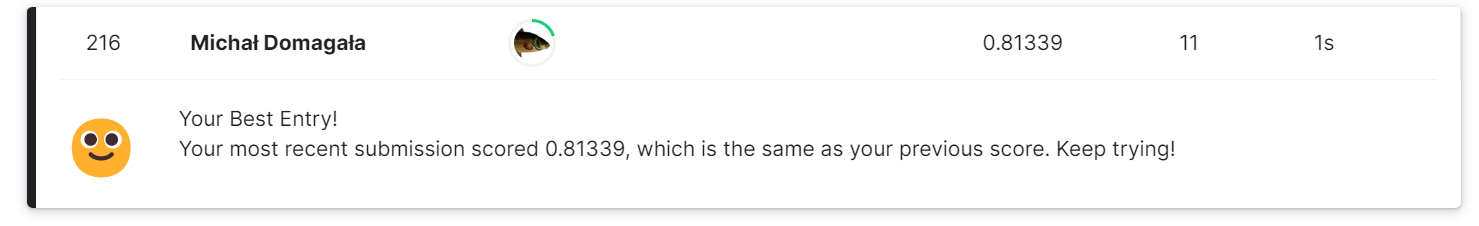

In [ ]:
grid_1.best_estimator_

In [ ]:
X_val

In [ ]:
X_train

In [14]:
X_val = preprocess_pipeline.transform(X_val)
X_train = preprocess_pipeline.transform(X_train)

In [ ]:
X_val = pd.DataFrame(X_val)
X_train = pd.DataFrame(X_train)

In [15]:
X_train

array([[-0.10520516,  0.83827931,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.02967173, -0.36022444,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.44587899,  0.83827931,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10520516,  0.83827931,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.92604307, -0.36022444,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.50174082, -1.55872819,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
X_val

array([[ 0.16454861,  0.83827931,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.37495892, -1.55872819,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.71215113, -1.55872819,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.02967173, -0.36022444,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.40867814,  0.83827931,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.44239736, -0.36022444,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

## Deep Learning

In [ ]:
#NEXT Pipeline

from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Dense

from keras.callbacks import History


model = Sequential()
model.add(Dense(4000,activation="relu", input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(2000,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1000,activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data= (X_val, y_val), batch_size=128, epochs=300)

model.evaluate(X_val,y_val)

from sklearn import  metrics
import matplotlib.pyplot as plt 

import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4000)              5596000   
                                                                 
 batch_normalization_4 (Batc  (None, 4000)             16000     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 2000)              8002000   
                                                                 
 batch_normalization_5 (Batc  (None, 2000)             8000      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 1000)              2001000   
                                                                 
 batch_normalization_6 (Batc  (None, 1000)            

6/6 [==============================] - 1s 89ms/step - loss: 4.5322e-05 - accuracy: 1.0000 - val_loss: 1.4557 - val_accuracy: 0.6313
Epoch 48/300
6/6 [==============================] - 1s 85ms/step - loss: 4.6305e-05 - accuracy: 1.0000 - val_loss: 1.4429 - val_accuracy: 0.6313
Epoch 49/300
6/6 [==============================] - 1s 91ms/step - loss: 3.1116e-05 - accuracy: 1.0000 - val_loss: 1.4309 - val_accuracy: 0.6313
Epoch 50/300
6/6 [==============================] - 1s 86ms/step - loss: 5.0379e-05 - accuracy: 1.0000 - val_loss: 1.4129 - val_accuracy: 0.6313
Epoch 51/300
6/6 [==============================] - 1s 86ms/step - loss: 7.7095e-05 - accuracy: 1.0000 - val_loss: 1.3977 - val_accuracy: 0.6313
Epoch 52/300
6/6 [==============================] - 1s 88ms/step - loss: 2.9754e-05 - accuracy: 1.0000 - val_loss: 1.3851 - val_accuracy: 0.6425
Epoch 53/300
6/6 [==============================] - 1s 86ms/step - loss: 3.0448e-05 - accuracy: 1.0000 - val_loss: 1.3693 - val_accuracy: 0.653

6/6 [==============================] - 0s 81ms/step - loss: 1.7617e-05 - accuracy: 1.0000 - val_loss: 0.9586 - val_accuracy: 0.8212
Epoch 104/300
6/6 [==============================] - 0s 81ms/step - loss: 1.0728e-05 - accuracy: 1.0000 - val_loss: 0.9614 - val_accuracy: 0.8268
Epoch 105/300
6/6 [==============================] - 0s 81ms/step - loss: 1.4227e-05 - accuracy: 1.0000 - val_loss: 0.9647 - val_accuracy: 0.8268
Epoch 106/300
6/6 [==============================] - 0s 83ms/step - loss: 1.4637e-05 - accuracy: 1.0000 - val_loss: 0.9679 - val_accuracy: 0.8268
Epoch 107/300
6/6 [==============================] - 1s 83ms/step - loss: 1.8934e-05 - accuracy: 1.0000 - val_loss: 0.9721 - val_accuracy: 0.8268
Epoch 108/300
6/6 [==============================] - 1s 86ms/step - loss: 1.3588e-05 - accuracy: 1.0000 - val_loss: 0.9762 - val_accuracy: 0.8324
Epoch 109/300
6/6 [==============================] - 0s 82ms/step - loss: 2.4137e-05 - accuracy: 1.0000 - val_loss: 0.9781 - val_accuracy:

6/6 [==============================] - 1s 87ms/step - loss: 1.2538e-05 - accuracy: 1.0000 - val_loss: 1.0738 - val_accuracy: 0.8324
Epoch 160/300
6/6 [==============================] - 1s 87ms/step - loss: 1.5258e-05 - accuracy: 1.0000 - val_loss: 1.0765 - val_accuracy: 0.8324
Epoch 161/300
6/6 [==============================] - 1s 85ms/step - loss: 1.5532e-05 - accuracy: 1.0000 - val_loss: 1.0762 - val_accuracy: 0.8324
Epoch 162/300
6/6 [==============================] - 1s 90ms/step - loss: 3.4657e-05 - accuracy: 1.0000 - val_loss: 1.0747 - val_accuracy: 0.8324
Epoch 163/300
6/6 [==============================] - 1s 85ms/step - loss: 9.3181e-06 - accuracy: 1.0000 - val_loss: 1.0743 - val_accuracy: 0.8324
Epoch 164/300
6/6 [==============================] - 1s 87ms/step - loss: 1.0930e-05 - accuracy: 1.0000 - val_loss: 1.0743 - val_accuracy: 0.8324
Epoch 165/300
6/6 [==============================] - 1s 90ms/step - loss: 6.4965e-06 - accuracy: 1.0000 - val_loss: 1.0741 - val_accuracy:

In [21]:
metrics.accuracy_score(y_true= y_val, y_pred= (model.predict(X_val)  > 0.5))


0.8435754189944135